In [ ]:
import re
import requests
from bs4 import BeautifulSoup, Comment

import pandas as pd
import numpy as np
from time import sleep

pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.max_columns', None)  # Show all columns

import warnings

# Suppress FutureWarning for pandas frame.append method
warnings.simplefilter(action='ignore', category=FutureWarning)

In [ ]:
def get_player_stats_by_game_table(target_url):
    response = requests.get(target_url).text
    bs=BeautifulSoup(response, 'lxml')
    per_game_table=bs.find_all('table', {'id':'per_game_stats'})
    data = pd.read_html(str(per_game_table))[0]
    return data

def get_player_stats_by_game(most_recent_full_season_finish_year = 2023, num_previous_seasons = 3, ignore_covid_season = True, position_filter = "null"):
    # get player stats by game from the most recent season
    url = f"https://www.basketball-reference.com/leagues/NBA_{most_recent_full_season_finish_year}_per_game.html"
    most_recent_season_data = get_player_stats_by_game_table(url)
    most_recent_season_data['season_yr_end'] = most_recent_full_season_finish_year

    # if the position filter is set to a position, remove all rows that don't have the correct position
    if position_filter != "null":
        most_recent_season_data = most_recent_season_data[most_recent_season_data['Pos'].str.contains(position_filter)]

    most_recent_season_data['Player'] = most_recent_season_data['Player'].str.replace('*', '')

    # Filter df to keep only the rows where "Tm" is "TOT" for players who have multiple rows
    multi_team_players = most_recent_season_data[most_recent_season_data.duplicated(subset='Player', keep=False) & (most_recent_season_data['Tm'] == 'TOT')]
    # Keep the rows for other players who don't have multiple rows
    other_players = most_recent_season_data[~most_recent_season_data.duplicated(subset='Player', keep=False)]
    # Concatenate the filtered rows with the rows for other players
    most_recent_season_data_final = pd.concat([multi_team_players, other_players])

    # iterate through previous seasons and fetch player stats by game for each previous season according to the number specified in function parameter
    combined_previous_season_data = pd.DataFrame()
    #if ignore_covid_season == True:
    #    num_previous_seasons += 1

    i = 1
    while (i <= num_previous_seasons):
        # if the year is covid year (2019 - 2020 season) ignore it if the flag is set
        if (most_recent_full_season_finish_year - i == 2020) and ignore_covid_season == True:
            i += 1
        else:
            url = f"https://www.basketball-reference.com/leagues/NBA_{most_recent_full_season_finish_year - i}_per_game.html"
            data_for_year = get_player_stats_by_game_table(url)
            data_for_year['season_yr_end'] = most_recent_full_season_finish_year - i

            # if the position filter is set to a position, remove all rows that don't have the correct position
            if position_filter != "null":
                data_for_year = data_for_year[data_for_year['Pos'].str.contains(position_filter)]

            # Filter df to keep only the rows where "Tm" is "TOT" for players who have multiple rows
            multi_team_players2 = data_for_year[data_for_year.duplicated(subset='Player', keep=False) & (data_for_year['Tm'] == 'TOT')]
            # Keep the rows for other players who don't have multiple rows
            other_players2 = data_for_year[~data_for_year.duplicated(subset='Player', keep=False)]
            # Concatenate the filtered rows with the rows for other players
            data_for_year_final = pd.concat([multi_team_players2, other_players2])

            # add the current iteratin's data to previous iteration's data
            combined_previous_season_data = pd.concat([combined_previous_season_data, data_for_year_final], ignore_index=True)
            i += 1

    combined_previous_season_data['Player'] = combined_previous_season_data['Player'].str.replace('*', '')

    return most_recent_season_data_final, combined_previous_season_data

In [ ]:
# EDIT THESE PARAMETERS
most_recent_full_season_year_end = 2023
num_previous_seasons = 3
ignore_covid_season = True

# list of included seasons
included_seasons_list = []
i = 1
if ignore_covid_season == True:
    num_previous_seasons += 1
while (i <= num_previous_seasons):
    # if the year is covid year (2019 - 2020 season) ignore it if the flag is set
    if (most_recent_full_season_year_end - i == 2020) and ignore_covid_season == True:
        i += 1
    else:
        included_seasons_list.append(most_recent_full_season_year_end - i)
        i += 1
included_seasons_list.append(most_recent_full_season_year_end)
test, train = get_player_stats_by_game(most_recent_full_season_year_end,num_previous_seasons,ignore_covid_season,'PG')
print(included_seasons_list)

[2022, 2021, 2019, 2023]


In [ ]:
# get a list of all players in either test or train, removing duplicates
players_combined = list(train['Player']) + list(test['Player'])
players_combined_unique = list(set(players_combined))

# extract first and last name for each player
first_names = []
last_names = []

# Iterate through each player name
for full_name in players_combined_unique:
    # Split the full name on spaces
    name_parts = full_name.split()

    first_name = name_parts[0]
    # identify the last name, ignoring suffixes
    if name_parts[-1] in ['Jr.', 'Sr.', 'IV', 'III', 'II']:
        last_name = name_parts[-2]
    else:
        last_name = name_parts[-1]

    first_names.append(first_name)
    last_names.append(last_name)

In [ ]:
# now we will use the names to populate a table of salary info with columns name, salary, and season_year
salary_info = pd.DataFrame()
j = 0
for first_name, last_name in zip(first_names, last_names):
    print(str(first_name) + str(last_name))

    # hard code to fix an error with certain players like J.J. Barea
    if first_name == "J.J.":
        first_name = "Jose"

    if first_name == 'Ashton' and last_name == 'Hagans':
        j += 1
        continue

    # remove special characters and punctuation from names with regexp
    first_name = re.sub(r'\W+', '', first_name)
    last_name = re.sub(r'\W+', '', last_name)

    # hard code to remove certain special letter characters and replace them with normal letters
    first_name = first_name.replace("č", "c")
    last_name = last_name.replace("č", "c")

    first_name = first_name.replace("ć", "c")
    last_name = last_name.replace("ć", "c")

    first_name = first_name.replace("é", "e")
    last_name = last_name.replace("é", "e")

    first_name = first_name.replace("ö", "o")
    last_name = last_name.replace("ö", "o")

    # We need the first 5 letters of last name and first 2 letters of first name of the URL in order to access it:
    player_code = last_name[:5].lower() + first_name[:2].lower()
    first_letter = last_name[0].lower()
    url = f"https://www.basketball-reference.com/players/{first_letter}/{player_code}01.html"

    # hard code to fix an error with Dennis Smith Jr.
    if first_name == 'Dennis' and last_name == 'Smith':
        url = f"https://www.basketball-reference.com/players/{first_letter}/{player_code}03.html"

    # hard code to fix an error with Frank Ntilikina
    if first_name == 'Frank' and last_name == 'Ntilikina':
        url = f"https://www.basketball-reference.com/players/n/ntilila01.html"

    # hard code to fix an error with Kevin Porter Jr.
    if first_name == 'Kevin' and last_name == 'Porter':
        url = f"https://www.basketball-reference.com/players/{first_letter}/{player_code}02.html"

    # perform a scrape for full_name
    print(url)
    response = requests.get(url).text
    full_name = re.findall(r'\n\t<h1>\n\t\t<span>(.+?)<\/span>', response)
    full_name = full_name[0]
    print(full_name)

    # hard code to skip Tyrone Washington
    if full_name == 'Tyrone Washington':
        j += 1
        continue
    # wait to avoid rate limit
    sleep(3.5)

    # performa scrape for salary table
    response = requests.get(url).text
    soup = BeautifulSoup(response, "lxml")
    soup = BeautifulSoup("\n".join(soup.find_all(text=Comment)), "lxml")

    salary_raw = pd.read_html(str(soup.select_one("table#all_salaries")))[0]
    #  remove "career" row aggregation and where the league is not NBA
    salary_raw = salary_raw.iloc[:-1]
    salary_raw = salary_raw[salary_raw['Lg'] == 'NBA']

    # format the dataframe and append to the end of total salary table
    salary_raw['season_year_end'] = salary_raw['Season'].apply(lambda x: int("20" + x.split('-')[1]))

    # some hard coding to fix fomatting errors
    salary_raw['Salary'] = salary_raw['Salary'].replace('< $Minimum', '0')
    salary_raw['Salary'] = salary_raw['Salary'].replace(' (TW)', '')
    salary_raw['Salary'] = salary_raw['Salary'].replace('(TW)', '0')
    #salary_raw['salary'] = salary_raw['Salary'].str.replace('$', '').str.replace(',', '').astype(int)
    salary_raw['salary'] = salary_raw['Salary'].str.replace('[^\d]', '').astype(int)

    salary_raw['name'] = full_name

    salary_processed = salary_raw[['season_year_end', 'salary', 'name']]
    salary_processed_grouped = salary_processed.groupby('season_year_end', as_index=False).agg({'salary':'sum', 'name':'first'})
    salary_processed_grouped = salary_processed_grouped[salary_processed_grouped['season_year_end'].isin(included_seasons_list)]

    salary_info = salary_info.append(salary_processed_grouped, ignore_index=True)

    # wait to avoid rate limit
    sleep(3.5)
    j += 1
    print('Percent complete: ' + str(round((j/len(first_names))*100, 2)) + "%")

salary_info

TreJones
https://www.basketball-reference.com/players/j/jonestr01.html
Tre Jones


<ipython-input-8-6efc59500fc2>:66: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  soup = BeautifulSoup("\n".join(soup.find_all(text=Comment)), "lxml")


Percent complete: 0.49%
JaylenAdams
https://www.basketball-reference.com/players/a/adamsja01.html
Jaylen Adams


<ipython-input-8-6efc59500fc2>:66: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  soup = BeautifulSoup("\n".join(soup.find_all(text=Comment)), "lxml")


Percent complete: 0.98%
JamareeBouyea
https://www.basketball-reference.com/players/b/bouyeja01.html
Jamaree Bouyea


<ipython-input-8-6efc59500fc2>:66: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  soup = BeautifulSoup("\n".join(soup.find_all(text=Comment)), "lxml")


Percent complete: 1.47%
DamianLillard
https://www.basketball-reference.com/players/l/lillada01.html
Damian Lillard


<ipython-input-8-6efc59500fc2>:66: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  soup = BeautifulSoup("\n".join(soup.find_all(text=Comment)), "lxml")


Percent complete: 1.96%
TerryRozier
https://www.basketball-reference.com/players/r/roziete01.html
Terry Rozier


KeyboardInterrupt: 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# save salary data to csv file (Steven)
salary_info = pd.read_csv('/salary_info.csv')

# merge into test and train
merged_train = pd.merge(train, salary_info, how='left', left_on=['Player', 'season_yr_end'], right_on=['name', 'season_year_end'])
merged_test = pd.merge(test, salary_info, how='left', left_on=['Player', 'season_yr_end'], right_on=['name', 'season_year_end'])

In [ ]:
# save salary data to csv file
salary_info.to_csv(r'C:\Users\richa\Documents\Academics\MSBA Program\Spring 2024\MKT 681 Sports Analytics\salary_info.csv', index=False)

# merge into test and train
merged_train = pd.merge(train, salary_info, how='left', left_on=['Player', 'season_yr_end'], right_on=['name', 'season_year_end'])
merged_test = pd.merge(test, salary_info, how='left', left_on=['Player', 'season_yr_end'], right_on=['name', 'season_year_end'])

In [ ]:
merged_train

,Rk,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,season_yr_end,season_year_end,salary,name
0,19,D.J. Augustin,PG,34,TOT,55,2,16.1,1.7,4.0,.423,1.2,3.0,.415,0.5,1.1,.448,.577,0.7,0.8,.884,0.2,1.0,1.2,1.9,0.3,0.0,1.0,0.7,5.3,2022,2022.0,7622467.0,D.J. Augustin
1,70,Armoni Brooks,SG-PG,23,TOT,54,11,15.6,1.8,5.4,.339,1.4,4.6,.297,0.4,0.7,.600,.467,0.3,0.4,.857,0.4,1.5,1.9,1.1,0.5,0.2,0.5,1.4,5.3,2022,2022.0,1910221.0,Armoni Brooks
2,95,Jevon Carter,PG,26,TOT,66,3,13.7,1.5,3.8,.387,1.0,2.6,.388,0.5,1.3,.386,.518,0.2,0.3,.833,0.2,1.5,1.7,1.5,0.4,0.2,0.5,1.0,4.2,2022,2022.0,4107149.0,Jevon Carter
3,139,Spencer Dinwiddie,PG,28,TOT,67,51,29.6,4.6,11.0,.416,1.7,4.9,.339,2.9,6.0,.479,.493,2.9,3.8,.774,0.7,3.5,4.2,5.2,0.7,0.2,1.6,2.2,13.7,2022,2022.0,17142857.0,Spencer Dinwiddie
4,147,Jeff Dowtin,PG,24,TOT,9,0,12.0,0.9,2.9,.308,0.1,1.0,.111,0.8,1.9,.412,.327,0.2,0.2,1.000,0.9,1.1,2.0,1.1,0.6,0.1,0.6,0.6,2.1,2022,2022.0,106352.0,Jeff Dowtin
5,149,Goran Dragić,PG,35,TOT,21,8,23.7,2.7,7.2,.377,0.8,3.0,.254,2.0,4.2,.466,.430,1.3,1.6,.818,0.6,2.5,3.1,4.1,0.9,0.2,1.6,2.1,7.5,2022,2022.0,19348907.0,Goran Dragić
6,177,Tim Frazier,PG,31,TOT,12,3,17.3,1.2,3.8,.311,0.5,1.4,.353,0.7,2.3,.286,.378,0.4,0.8,.556,0.4,1.2,1.6,2.8,0.3,0.1,1.3,2.3,3.3,2022,2022.0,386127.0,Tim Frazier
7,214,Tyrese Haliburton,SG-PG,21,TOT,77,77,35.0,5.6,11.8,.473,2.1,5.1,.414,3.5,6.8,.517,.562,2.1,2.5,.842,0.8,3.2,4.0,8.2,1.7,0.6,2.6,1.6,15.3,2022,2022.0,4023600.0,Tyrese Haliburton
8,218,James Harden,PG,32,TOT,65,65,37.2,6.3,15.3,.410,2.3,6.9,.330,4.0,8.4,.476,.485,7.2,8.2,.877,0.8,6.8,7.7,10.3,1.3,0.6,4.4,2.4,22.0,2022,2022.0,44310840.0,James Harden
9,244,Aaron Holiday,PG,25,TOT,63,15,16.2,2.4,5.4,.447,0.6,1.6,.379,1.8,3.7,.477,.504,0.9,1.1,.868,0.4,1.6,1.9,2.4,0.7,0.1,1.1,1.5,6.3,2022,2022.0,3980551.0,Aaron Holiday


In [ ]:
merged_test

,Rk,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,season_yr_end,season_year_end,salary,name
0,15,Ryan Arcidiacono,PG,28,TOT,20,4,8.6,0.5,1.9,.243,0.4,1.2,.348,0.1,0.7,.071,.351,0.0,0.0,NaN,0.0,0.8,0.8,1.2,0.3,0.0,0.4,0.9,1.3,2023,2023.0,1836090.0,Ryan Arcidiacono
1,39,Patrick Beverley,SG-PG,34,TOT,67,67,27.1,2.1,5.4,.400,1.2,3.6,.335,1.0,1.8,.529,.511,0.7,1.0,.723,0.7,3.0,3.7,2.9,0.9,0.6,0.9,2.8,6.2,2023,2023.0,13506508.0,Patrick Beverley
2,53,Jamaree Bouyea,PG,23,TOT,5,0,14.2,1.2,2.8,.429,0.4,1.2,.333,0.8,1.6,.500,.500,0.2,0.4,.500,0.2,1.0,1.2,0.8,0.8,0.4,0.8,1.2,3.0,2023,2023.0,116986.0,Jamaree Bouyea
3,99,Mike Conley,PG,35,TOT,67,66,30.3,3.9,9.1,.428,2.0,5.2,.385,1.9,3.9,.486,.539,2.1,2.5,.834,0.5,2.2,2.7,6.7,1.1,0.2,1.5,2.1,11.9,2023,2023.0,22680000.0,Mike Conley
4,123,Spencer Dinwiddie,SG-PG,29,TOT,79,79,34.5,5.8,13.3,.438,2.3,6.2,.369,3.5,7.1,.498,.524,3.4,4.2,.812,0.4,3.1,3.4,6.5,0.8,0.3,1.8,2.4,17.3,2023,2023.0,19500000.0,Spencer Dinwiddie
5,132,Goran Dragić,PG,36,TOT,58,0,15.0,2.4,5.8,.421,0.9,2.5,.359,1.5,3.3,.468,.499,0.5,0.8,.689,0.3,1.1,1.4,2.6,0.2,0.1,1.1,1.1,6.3,2023,2023.0,2226523.0,Goran Dragić
6,171,Devonte' Graham,PG,27,TOT,73,8,18.3,2.2,5.9,.374,1.6,4.6,.352,0.6,1.3,.452,.512,1.3,1.8,.748,0.3,1.4,1.7,2.7,0.6,0.2,0.7,1.1,7.4,2023,2023.0,11550000.0,Devonte' Graham
7,211,George Hill,PG-SG,36,TOT,46,1,18.1,1.7,3.6,.470,0.7,2.1,.358,1.0,1.5,.620,.572,0.9,1.2,.764,0.3,1.5,1.8,2.4,0.6,0.1,0.7,1.2,5.0,2023,2023.0,4000000.0,George Hill
8,225,Bones Hyland,PG,22,TOT,56,1,19.4,4.1,10.2,.399,2.1,5.6,.371,2.0,4.6,.434,.502,1.5,1.8,.843,0.4,2.1,2.4,3.1,0.7,0.3,1.5,1.7,11.8,2023,2023.0,2201520.0,Bones Hyland
9,230,Kyrie Irving,PG-SG,30,TOT,60,60,37.4,9.9,20.1,.494,3.1,8.3,.379,6.8,11.8,.574,.572,4.1,4.6,.905,1.0,4.1,5.1,5.5,1.1,0.8,2.1,2.8,27.1,2023,2023.0,38917057.0,Kyrie Irving


## Data Cleaning

In [ ]:
# Convert 'PTS', 'AST', and 'TOV' columns to numeric types to avoid TypeError when modeling
merged_train['PTS'] = pd.to_numeric(merged_train['PTS'], errors='coerce')
merged_train['AST'] = pd.to_numeric(merged_train['AST'], errors='coerce')
merged_train['TOV'] = pd.to_numeric(merged_train['TOV'], errors='coerce')
merged_train['salary'] = pd.to_numeric(merged_train['salary'], errors='coerce')

merged_test['PTS'] = pd.to_numeric(merged_test['PTS'], errors='coerce')
merged_test['AST'] = pd.to_numeric(merged_test['AST'], errors='coerce')
merged_test['TOV'] = pd.to_numeric(merged_test['TOV'], errors='coerce')
merged_test['salary'] = pd.to_numeric(merged_test['salary'], errors='coerce')

In [ ]:
# Replace 'inf' with NaN so we can drop null values all together
merged_train.replace([np.inf, -np.inf], np.nan, inplace=True)
merged_test.replace([np.inf, -np.inf], np.nan, inplace=True)

In [ ]:
# Replace 'inf' with NaN so we can drop null values all together
merged_train.replace([np.inf, -np.inf], np.nan, inplace=True)
merged_test.replace([np.inf, -np.inf], np.nan, inplace=True)

Assign weights for important data scraped metric.
For a point guard, these metrics are most important in determining their performance (ordered by importance):
*   Points (PTS) weight: 0.5
  - points determine team winning so most important
*   Assists (AST) weight: 0.3
  - assist is a sub-category of points, when correctly assisted by point guard, the shooter scores and the assist point goes up
*   Turnovers (TOV) weight: -0.2 (negative because turnovers are undesirable for our team)
  - lower turnover means that opponents aren't taking our team's ball, which is critical for a point guard who's responsible of assisting/passing balls

The performance rating formula will then be:
Performance Rating =(PTS×weight for PTS)+(AST×weight for AST)+(TOV×weight for TOV)

with
CPI
= Base Salary /
Performance Rating


In [ ]:
# Calculate CPI for train dataset
# Define weights for performance metrics
weights = {'PTS': 0.5, 'AST': 0.3, 'TOV': -0.2}

# Calculate performance rating
merged_train['Performance Rating'] = (merged_train['PTS'] * weights['PTS']) + \
                                          (merged_train['AST'] * weights['AST']) + \
                                          (merged_train['TOV'] * weights['TOV'])

# Calculate CPI
merged_train['CPI'] = merged_train['salary'] / merged_train['Performance Rating']
merged_train[['name', 'Performance Rating', 'CPI']]

,name,Performance Rating,CPI
0,D.J. Augustin,3.02,2.523996e+06
1,Armoni Brooks,2.88,6.632712e+05
2,Jevon Carter,2.45,1.676387e+06
3,Spencer Dinwiddie,8.09,2.119018e+06
4,Jeff Dowtin,1.26,8.440635e+04
5,Goran Dragić,4.66,4.152126e+06
6,Tim Frazier,2.23,1.731511e+05
7,Tyrese Haliburton,9.59,4.195620e+05
8,James Harden,13.21,3.354341e+06
9,Aaron Holiday,3.65,1.090562e+06


In [ ]:
# Calculate CPI for test dataset
# Define weights for performance metrics
weights = {'PTS': 0.5, 'AST': 0.3, 'TOV': -0.2}

# Calculate performance rating
merged_test['Performance Rating'] = (merged_test['PTS'] * weights['PTS']) + \
                                          (merged_test['AST'] * weights['AST']) + \
                                          (merged_test['TOV'] * weights['TOV'])

# Calculate CPI
merged_test['CPI'] = merged_test['salary'] / merged_test['Performance Rating']
merged_test[['name', 'Performance Rating', 'CPI']]

,name,Performance Rating,CPI
0,Ryan Arcidiacono,0.93,1.974290e+06
1,Patrick Beverley,3.79,3.563722e+06
2,Jamaree Bouyea,1.58,7.404177e+04
3,Mike Conley,7.66,2.960836e+06
4,Spencer Dinwiddie,10.24,1.904297e+06
5,Goran Dragić,3.71,6.001410e+05
6,Devonte' Graham,4.37,2.643021e+06
7,George Hill,3.08,1.298701e+06
8,Bones Hyland,6.53,3.371394e+05
9,Kyrie Irving,14.78,2.633089e+06


In [ ]:
# Replace 'inf' with NaN so we can drop null values all together again
merged_train.replace([np.inf, -np.inf], np.nan, inplace=True)
merged_test.replace([np.inf, -np.inf], np.nan, inplace=True)

In [ ]:
# Drop rows where CPI is null again
merged_train = merged_train.dropna(subset=['CPI'])
merged_test = merged_test.dropna(subset=['CPI'])

In [ ]:
# final check
merged_train

,Rk,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,season_yr_end,season_year_end,salary,name,Performance Rating,CPI
0,19,D.J. Augustin,PG,34,TOT,55,2,16.1,1.7,4.0,.423,1.2,3.0,.415,0.5,1.1,.448,.577,0.7,0.8,.884,0.2,1.0,1.2,1.9,0.3,0.0,1.0,0.7,5.3,2022,2022.0,7622467.0,D.J. Augustin,3.02,2.523996e+06
1,70,Armoni Brooks,SG-PG,23,TOT,54,11,15.6,1.8,5.4,.339,1.4,4.6,.297,0.4,0.7,.600,.467,0.3,0.4,.857,0.4,1.5,1.9,1.1,0.5,0.2,0.5,1.4,5.3,2022,2022.0,1910221.0,Armoni Brooks,2.88,6.632712e+05
2,95,Jevon Carter,PG,26,TOT,66,3,13.7,1.5,3.8,.387,1.0,2.6,.388,0.5,1.3,.386,.518,0.2,0.3,.833,0.2,1.5,1.7,1.5,0.4,0.2,0.5,1.0,4.2,2022,2022.0,4107149.0,Jevon Carter,2.45,1.676387e+06
3,139,Spencer Dinwiddie,PG,28,TOT,67,51,29.6,4.6,11.0,.416,1.7,4.9,.339,2.9,6.0,.479,.493,2.9,3.8,.774,0.7,3.5,4.2,5.2,0.7,0.2,1.6,2.2,13.7,2022,2022.0,17142857.0,Spencer Dinwiddie,8.09,2.119018e+06
4,147,Jeff Dowtin,PG,24,TOT,9,0,12.0,0.9,2.9,.308,0.1,1.0,.111,0.8,1.9,.412,.327,0.2,0.2,1.000,0.9,1.1,2.0,1.1,0.6,0.1,0.6,0.6,2.1,2022,2022.0,106352.0,Jeff Dowtin,1.26,8.440635e+04
5,149,Goran Dragić,PG,35,TOT,21,8,23.7,2.7,7.2,.377,0.8,3.0,.254,2.0,4.2,.466,.430,1.3,1.6,.818,0.6,2.5,3.1,4.1,0.9,0.2,1.6,2.1,7.5,2022,2022.0,19348907.0,Goran Dragić,4.66,4.152126e+06
6,177,Tim Frazier,PG,31,TOT,12,3,17.3,1.2,3.8,.311,0.5,1.4,.353,0.7,2.3,.286,.378,0.4,0.8,.556,0.4,1.2,1.6,2.8,0.3,0.1,1.3,2.3,3.3,2022,2022.0,386127.0,Tim Frazier,2.23,1.731511e+05
7,214,Tyrese Haliburton,SG-PG,21,TOT,77,77,35.0,5.6,11.8,.473,2.1,5.1,.414,3.5,6.8,.517,.562,2.1,2.5,.842,0.8,3.2,4.0,8.2,1.7,0.6,2.6,1.6,15.3,2022,2022.0,4023600.0,Tyrese Haliburton,9.59,4.195620e+05
8,218,James Harden,PG,32,TOT,65,65,37.2,6.3,15.3,.410,2.3,6.9,.330,4.0,8.4,.476,.485,7.2,8.2,.877,0.8,6.8,7.7,10.3,1.3,0.6,4.4,2.4,22.0,2022,2022.0,44310840.0,James Harden,13.21,3.354341e+06
9,244,Aaron Holiday,PG,25,TOT,63,15,16.2,2.4,5.4,.447,0.6,1.6,.379,1.8,3.7,.477,.504,0.9,1.1,.868,0.4,1.6,1.9,2.4,0.7,0.1,1.1,1.5,6.3,2022,2022.0,3980551.0,Aaron Holiday,3.65,1.090562e+06


In [ ]:
# final check
merged_test

,Rk,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,season_yr_end,season_year_end,salary,name,Performance Rating,CPI
0,15,Ryan Arcidiacono,PG,28,TOT,20,4,8.6,0.5,1.9,.243,0.4,1.2,.348,0.1,0.7,.071,.351,0.0,0.0,NaN,0.0,0.8,0.8,1.2,0.3,0.0,0.4,0.9,1.3,2023,2023.0,1836090.0,Ryan Arcidiacono,0.93,1.974290e+06
1,39,Patrick Beverley,SG-PG,34,TOT,67,67,27.1,2.1,5.4,.400,1.2,3.6,.335,1.0,1.8,.529,.511,0.7,1.0,.723,0.7,3.0,3.7,2.9,0.9,0.6,0.9,2.8,6.2,2023,2023.0,13506508.0,Patrick Beverley,3.79,3.563722e+06
2,53,Jamaree Bouyea,PG,23,TOT,5,0,14.2,1.2,2.8,.429,0.4,1.2,.333,0.8,1.6,.500,.500,0.2,0.4,.500,0.2,1.0,1.2,0.8,0.8,0.4,0.8,1.2,3.0,2023,2023.0,116986.0,Jamaree Bouyea,1.58,7.404177e+04
3,99,Mike Conley,PG,35,TOT,67,66,30.3,3.9,9.1,.428,2.0,5.2,.385,1.9,3.9,.486,.539,2.1,2.5,.834,0.5,2.2,2.7,6.7,1.1,0.2,1.5,2.1,11.9,2023,2023.0,22680000.0,Mike Conley,7.66,2.960836e+06
4,123,Spencer Dinwiddie,SG-PG,29,TOT,79,79,34.5,5.8,13.3,.438,2.3,6.2,.369,3.5,7.1,.498,.524,3.4,4.2,.812,0.4,3.1,3.4,6.5,0.8,0.3,1.8,2.4,17.3,2023,2023.0,19500000.0,Spencer Dinwiddie,10.24,1.904297e+06
5,132,Goran Dragić,PG,36,TOT,58,0,15.0,2.4,5.8,.421,0.9,2.5,.359,1.5,3.3,.468,.499,0.5,0.8,.689,0.3,1.1,1.4,2.6,0.2,0.1,1.1,1.1,6.3,2023,2023.0,2226523.0,Goran Dragić,3.71,6.001410e+05
6,171,Devonte' Graham,PG,27,TOT,73,8,18.3,2.2,5.9,.374,1.6,4.6,.352,0.6,1.3,.452,.512,1.3,1.8,.748,0.3,1.4,1.7,2.7,0.6,0.2,0.7,1.1,7.4,2023,2023.0,11550000.0,Devonte' Graham,4.37,2.643021e+06
7,211,George Hill,PG-SG,36,TOT,46,1,18.1,1.7,3.6,.470,0.7,2.1,.358,1.0,1.5,.620,.572,0.9,1.2,.764,0.3,1.5,1.8,2.4,0.6,0.1,0.7,1.2,5.0,2023,2023.0,4000000.0,George Hill,3.08,1.298701e+06
8,225,Bones Hyland,PG,22,TOT,56,1,19.4,4.1,10.2,.399,2.1,5.6,.371,2.0,4.6,.434,.502,1.5,1.8,.843,0.4,2.1,2.4,3.1,0.7,0.3,1.5,1.7,11.8,2023,2023.0,2201520.0,Bones Hyland,6.53,3.371394e+05
9,230,Kyrie Irving,PG-SG,30,TOT,60,60,37.4,9.9,20.1,.494,3.1,8.3,.379,6.8,11.8,.574,.572,4.1,4.6,.905,1.0,4.1,5.1,5.5,1.1,0.8,2.1,2.8,27.1,2023,2023.0,38917057.0,Kyrie Irving,14.78,2.633089e+06


## EDA about CPIs

In [ ]:
summary_stats = merged_train[['PTS', 'AST', 'TOV']].describe()
print(summary_stats)

# Calculate correlation matrix
correlation_matrix = merged_train[['PTS', 'AST', 'TOV']].corr()
print(correlation_matrix)

              PTS         AST         TOV
count  301.000000  301.000000  301.000000
mean     9.778073    3.716944    1.475748
std      7.188745    2.462061    1.049846
min      0.000000    0.000000    0.000000
25%      4.300000    1.800000    0.700000
50%      7.600000    3.300000    1.200000
75%     13.700000    5.400000    2.200000
max     36.100000   11.700000    5.000000
          PTS       AST       TOV
PTS  1.000000  0.813880  0.860722
AST  0.813880  1.000000  0.902246
TOV  0.860722  0.902246  1.000000


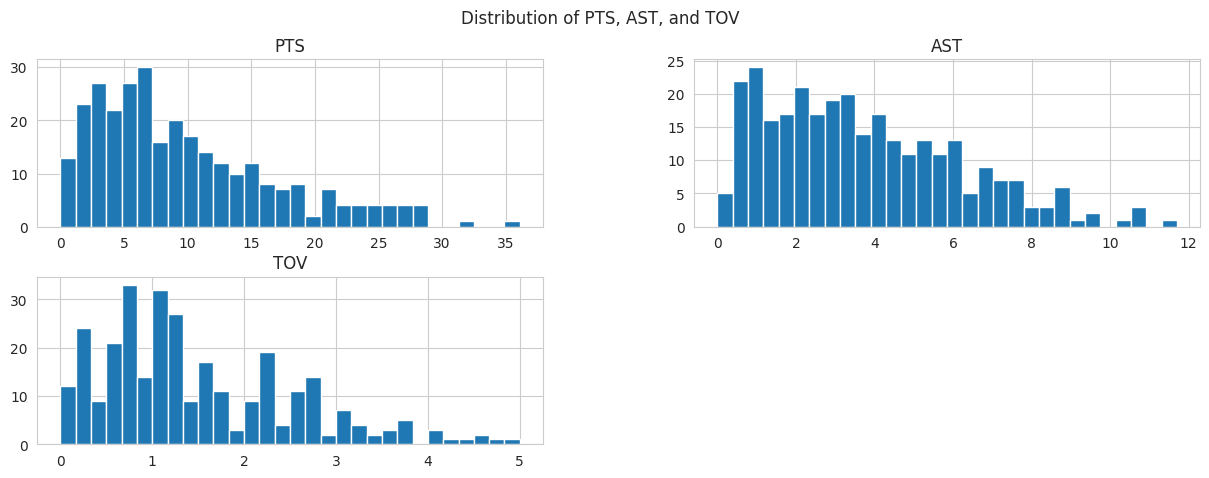

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

# Plot histograms
merged_train[['PTS', 'AST', 'TOV']].hist(bins=30, figsize=(15, 5))
plt.suptitle('Distribution of PTS, AST, and TOV')
plt.show()

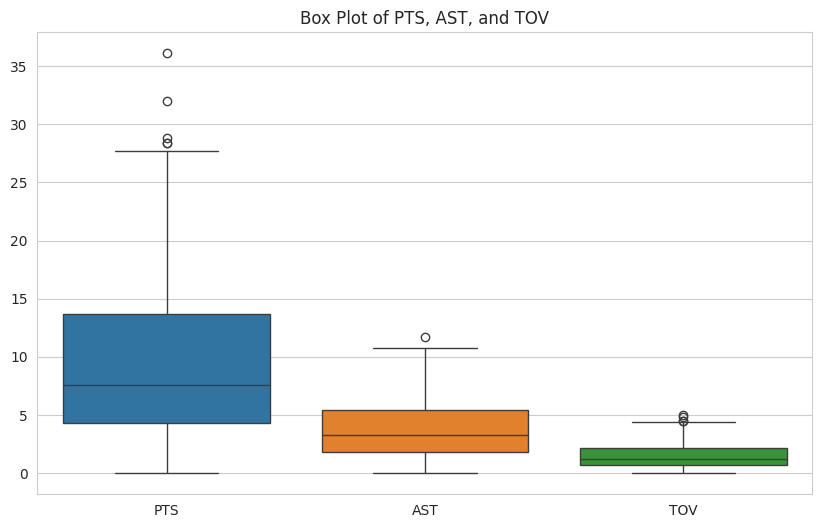

In [ ]:
# Plot box plots
plt.figure(figsize=(10, 6))
sns.boxplot(data=merged_train[['PTS', 'AST', 'TOV']])
plt.title('Box Plot of PTS, AST, and TOV')
plt.show()

In [ ]:
#Outlier Detection
Q1 = np.percentile(merged_train['CPI'], 25)
Q3 = np.percentile(merged_train['CPI'], 75)
IQR = Q3 - Q1

# Determine outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = merged_train[(merged_train['CPI'] < lower_bound) | (merged_train['CPI'] > upper_bound)]

In [ ]:
outliers

,Rk,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,season_yr_end,season_year_end,salary,name,Performance Rating,CPI
5,149,Goran Dragić,PG,35,TOT,21,8,23.7,2.7,7.2,.377,0.8,3.0,.254,2.0,4.2,.466,.430,1.3,1.6,.818,0.6,2.5,3.1,4.1,0.9,0.2,1.6,2.1,7.5,2022,2022.0,19348907.0,Goran Dragić,4.66,4.152126e+06
107,576,Russell Westbrook,PG,33,LAL,78,78,34.3,7.0,15.8,.444,1.0,3.4,.298,6.0,12.4,.485,.476,3.4,5.1,.667,1.4,6.0,7.4,7.1,1.0,0.3,3.8,3.0,18.5,2022,2022.0,44211146.0,Russell Westbrook,10.62,4.163008e+06
150,139,Kris Dunn,PG,26,ATL,4,0,11.3,0.3,3.0,.083,0.0,0.5,.000,0.3,2.5,.100,.083,0.8,1.0,.750,0.0,1.5,1.5,0.5,0.5,0.5,0.8,2.5,1.3,2021,2021.0,4767000.0,Kris Dunn,0.64,7.448438e+06
193,370,Frank Ntilikina,PG,22,NYK,33,4,9.8,0.9,2.4,.367,0.7,1.5,.479,0.2,0.9,.194,.513,0.2,0.5,.444,0.2,0.8,0.9,0.6,0.5,0.1,0.3,1.4,2.7,2021,2021.0,6176578.0,Frank Ntilikina,1.47,4.201754e+06
195,396,Chris Paul,PG,35,PHO,70,70,31.4,6.3,12.6,.499,1.5,3.7,.395,4.8,8.9,.543,.557,2.4,2.6,.934,0.4,4.1,4.5,8.9,1.4,0.3,2.2,2.4,16.4,2021,2021.0,41358814.0,Chris Paul,10.43,3.965370e+06
226,228,George Hill,PG,32,TOT,60,13,21.7,2.8,6.3,.452,0.8,2.6,.314,2.0,3.7,.547,.516,1.2,1.4,.824,0.7,1.8,2.5,2.3,0.9,0.1,0.9,1.7,7.6,2019,2019.0,19000000.0,George Hill,4.31,4.408353e+06
316,485,Evan Turner,PG,30,POR,73,2,22.0,2.8,6.1,.460,0.2,0.7,.212,2.6,5.4,.494,.473,1.0,1.5,.708,0.5,4.0,4.5,3.9,0.5,0.2,1.6,1.5,6.8,2019,2019.0,17868853.0,Evan Turner,4.25,4.204436e+06


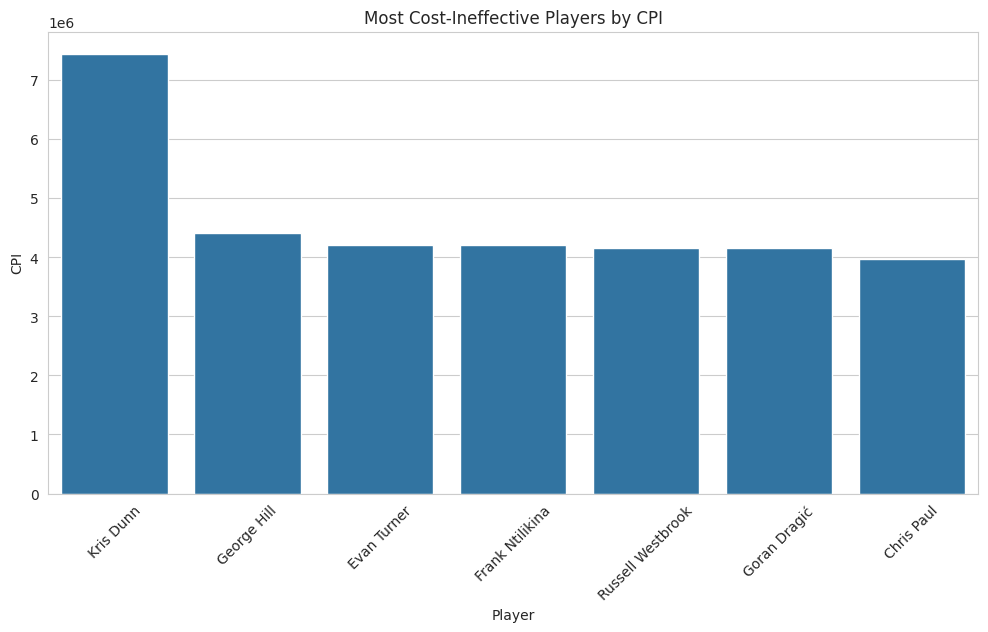

In [ ]:
# Ranking by CPI - Showing top 10 players
outliers_players = outliers.sort_values('CPI', ascending=False).head(10)
plt.figure(figsize=(12, 6))
sns.barplot(data=outliers_players, x='Player', y='CPI')
plt.title('Most Cost-effective Players by CPI')
plt.xlabel('Player')
plt.ylabel('CPI')
plt.xticks(rotation=45)
plt.show()

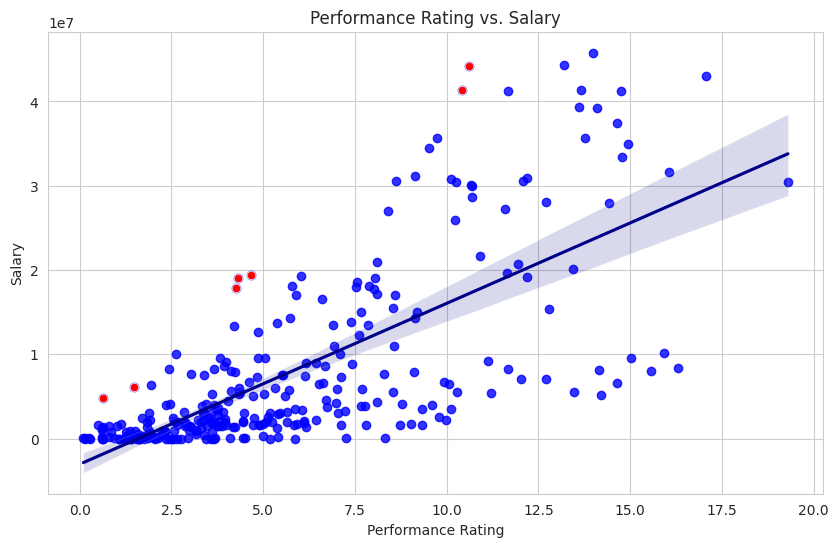

In [ ]:
# CPI and Salary Correlation
plt.figure(figsize=(10, 6))
sns.regplot(data=merged_train, x='Performance Rating', y='salary', scatter_kws={'color': 'blue'}, line_kws={'color': 'darkblue'})
sns.scatterplot(data=outliers, color = "red", x='Performance Rating', y='salary')
plt.title('Performance Rating vs. Salary')
plt.xlabel('Performance Rating')
plt.ylabel('Salary')
plt.show()

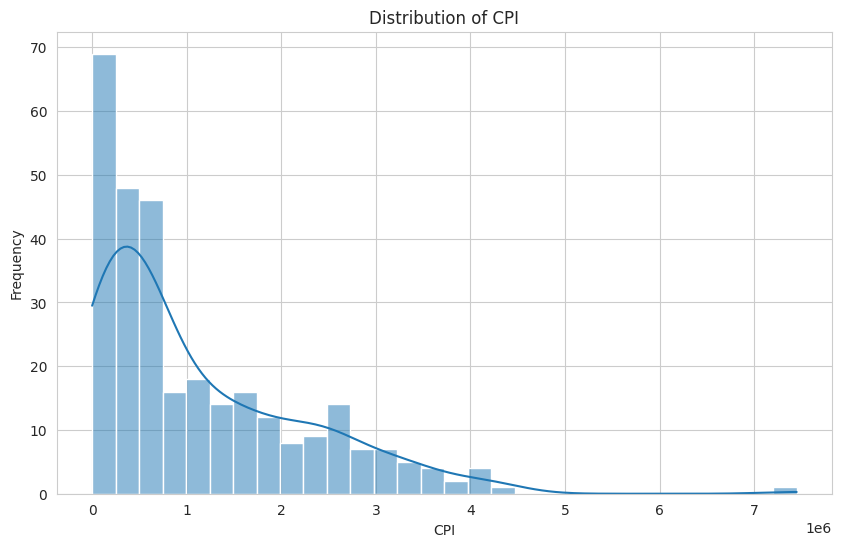

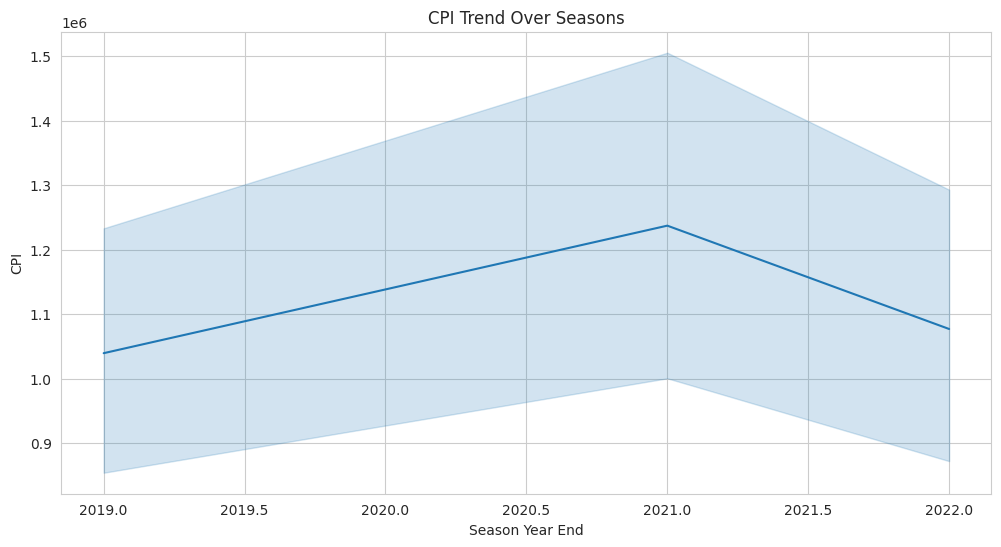

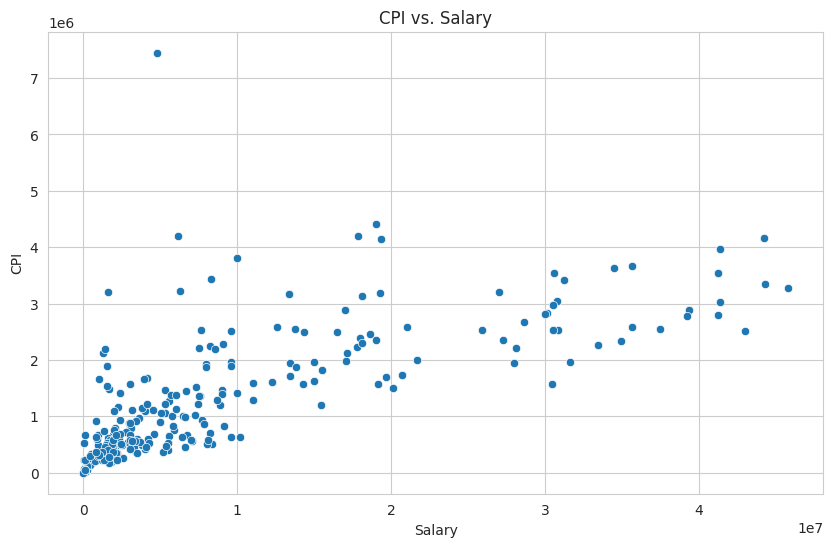

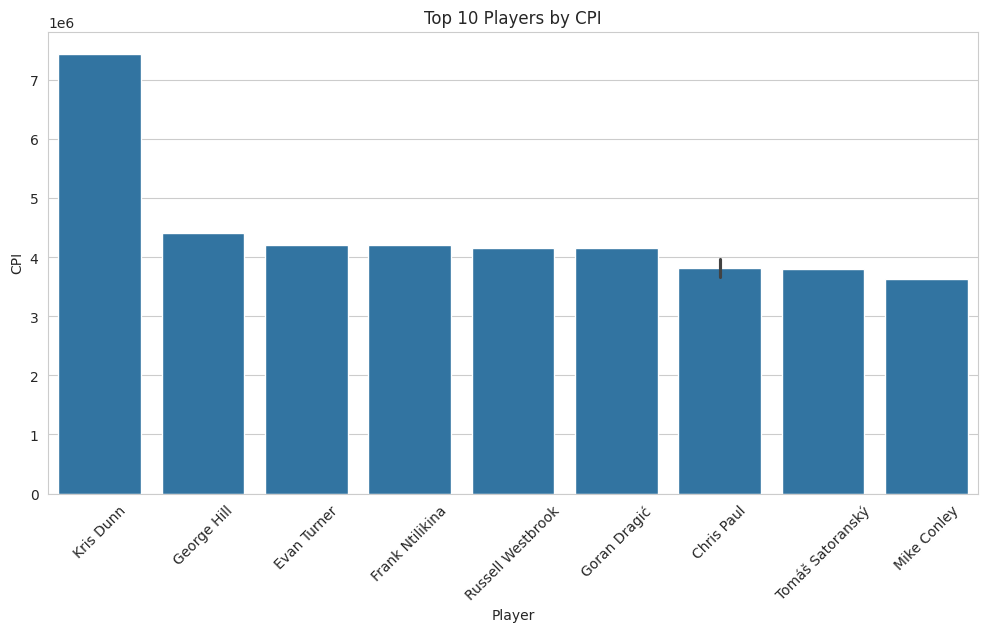

In [ ]:
# CPI EDA

# CPI Distribution
plt.figure(figsize=(10, 6))
sns.histplot(merged_train['CPI'], bins=30, kde=True)
plt.title('Distribution of CPI')
plt.xlabel('CPI')
plt.ylabel('Frequency')
plt.show()

# CPI Trends Over Seasons (if your data includes multiple seasons)
plt.figure(figsize=(12, 6))
sns.lineplot(data=merged_train, x='season_yr_end', y='CPI')
plt.title('CPI Trend Over Seasons')
plt.xlabel('Season Year End')
plt.ylabel('CPI')
plt.show()

# CPI and Salary Correlation
plt.figure(figsize=(10, 6))
sns.scatterplot(data=merged_train, x='salary', y='CPI')
plt.title('CPI vs. Salary')
plt.xlabel('Salary')
plt.ylabel('CPI')
plt.show()

# Ranking by CPI - Showing top 10 players
top_players = merged_train.sort_values('CPI', ascending=False).head(10)
plt.figure(figsize=(12, 6))
sns.barplot(data=top_players, x='Player', y='CPI')
plt.title('Top 10 Players by CPI')
plt.xlabel('Player')
plt.ylabel('CPI')
plt.xticks(rotation=45)
plt.show()

1. Distribution of CPI: The histogram shows that CPI values are mostly concentrated around the lower end, indicating a right-skewed distribution. Most players have a CPI value close to 0, with fewer players achieving a higher CPI. The presence of a long tail towards the higher CPI values suggests that while most players perform within a similar range, a few outperform significantly.

2. CPI Trend Over Seasons: CPI experienced an overall increasing trend from 2019 to around mid-2021, followed by a decrease towards 2022 (because we don't have that much data after 23). The shaded area shows variability in the CPI across the seasons, with some fluctuation between the periods.

3. CPI vs. Salary: The scatter plot does not show a clear linear relationship between salary and CPI, with many players clustered at the lower end of both salary and CPI. While there is a general trend that higher salaries correspond to higher CPI values, there are numerous exceptions, indicating that salary alone is not a consistent predictor of CPI.

4. Top 10 Players by CPI: The bar chart displays the top 10 players ranked by CPI, with the player "Kobi Simmons" having the highest CPI among them. The bars are quite close in height, which shows that top performers by CPI are within a similar range of performance.


Overall, CPI does vary among players, with most having lower CPI values (yay, it shows that most players are more cost-effective measured with 3 performance metrics and salary) with few exceptional players having significantly higher values. This variability is a good sign that CPI could be capturing some aspects of player efficiency.

## Modeling

Used xgboost because
1. variables show a high degree of correlation with each other. High correlations between features can sometimes lead to multicollinearity, which can be problematic for some models, but tree-based models like XGBoost are generally robust to multicollinearity.

2. XGBoost does not assume any distribution of the features. Our X variables doesn't show unison in normal distribution.

3. XGBoost is quite robust to outliers and we see 'PTS' having high outliers

In [ ]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [ ]:
X_train = merged_train[['PTS', 'AST', 'TOV']]
y_train = merged_train['CPI']
X_test = merged_test[['PTS', 'AST', 'TOV']]
y_test = merged_test['CPI']


X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Train model
dtrain = xgb.DMatrix(X_train, label=y_train, enable_categorical=True)
dtest = xgb.DMatrix(X_test, label=y_test, enable_categorical=True)


params = {
    'max_depth': 3,
    'eta': 0.3,
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse'
}
num_rounds = 100


bst = xgb.train(params, dtrain, num_rounds, evals=[(dtest, 'test')], early_stopping_rounds=10)

# Test CPI
X_test = merged_test[['PTS', 'AST', 'TOV']]
dtest = xgb.DMatrix(X_test)


y_pred = bst.predict(dtest)

# add to our dataframe
merged_test['Predicted CPI'] = y_pred

# Evaluate
# chose RMSE for XGBoost model bc it's sensitive to outliers and it penalizes big errors (needed when we are trying to determine player's efficiency based on performance and salary)
if 'CPI' in merged_test:
    y_true = merged_test['CPI']
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    print(f"RMSE: {rmse}")


[0]	test-rmse:1202870.50067
[1]	test-rmse:1183207.70420
[2]	test-rmse:1190195.36710
[3]	test-rmse:1196155.51082
[4]	test-rmse:1198361.75830
[5]	test-rmse:1207054.66403
[6]	test-rmse:1205424.11401
[7]	test-rmse:1208394.02428
[8]	test-rmse:1220646.79106
[9]	test-rmse:1228959.88327
[10]	test-rmse:1240517.52107
RMSE: 1445901.404284252


Result:
The output from XGBoost model, final RMSE of 1,445,901, suggests that the model's ability to accurately predict the Cost Performance Index (CPI) for players based on their performance metrics (points, assists, turnovers) is limited. Thus, CPI might be a good metric for predictions, but we can incorporate different models to accurately predict player efficiency.

In the context of assessing whether players are worth their contracts by evaluating their cap efficiency over the past season, the high RMSE value indicates significant discrepancies between the predicted CPI values and actual contract values. -- In the report we should focus more on explaining why we used CPI + domain knowledge + data scraping method than using xgboost model. Model is just for brownie points and that CPI works lmao